<a href="https://colab.research.google.com/github/angelafrocha/ProjetoSoulcode/blob/main/dataset_vendas_marcas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1) Instalação das bibliotecas


Instalando pandera para validação do Schema após a tranformação dos dados, a biblioteca do GCP para extrair os dados do bucket e o pymongo para acesso ao Mongo DB

In [ ]:
pip install pandera

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.6 MB/s eta 0:00:00


In [ ]:
pip install pymongo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 8.0 MB/s eta 0:00:00


##2) importação das bibliotecas


In [ ]:
import pandas as pd
import numpy as np
import pandera as pa
import matplotlib.pyplot as plt
from google.cloud import storage
import os
import pymongo
from pymongo import MongoClient

##3) Conectores


###Conector MongoDB

In [ ]:
#conector para o MongoDB

uri = "mongodb+srv://clustere5.wjshwzt.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/acessoautoinsight.pem',
                     )

db = client['vendas_marca']
colecao = db['tratado']

In [ ]:
doc_count = colecao.count_documents({})
print(doc_count)

0


###Conexão com o google cloud Storage

In [ ]:
#configuração da chave de segurança para acesso ao bucket
serviceAccount = '/content/chave_bucketProjetoFinal.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
#Configurações Google Cloud Storage
client = storage.Client()
bucket = client.get_bucket('projetofinal1')
bucket.blob('licenciamento_veiculos_empresa_2012-2023.xlsx')
path = 'gs://projetofinal1/brutos/licenciamento_veiculos_empresa_2012-2023.xlsx'

##4) Extração dos dados

In [ ]:
#extraindo o dataset do bucket
df = pd.read_excel(path)

##5) Análise exploratória


In [ ]:
#amostra do dataframe
df

,nome_marca,qtd_veiculos,mes_ano
0,Audi,369.0,2012-01-01
1,BMW,775.0,2012-01-01
2,Mini,211.0,2012-01-01
3,Hyundai,6995.0,2012-01-01
4,Subaru,115.0,2012-01-01
...,...,...,...
3748,Renault,9677.0,2023-03-01
3749,Toyota,12924.0,2023-03-01
3750,Lexus,30.0,2023-03-01
3751,Volkswagen,20155.0,2023-03-01


In [ ]:
#verificando o tipo de dados presente em cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   nome_marca    3753 non-null   object        
 1   qtd_veiculos  3752 non-null   float64       
 2   mes_ano       3753 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 88.1+ KB


In [ ]:
#shape do dataframe

df.shape

(3753, 3)

In [ ]:
#verificando valores únicos dentro da coluna nome_marca em formato de lista
sorted(pd.unique(df['nome_marca']))

['Audi',
 'BMW',
 'Caoa Chery',
 'Chrysler',
 'Citroën',
 'Dodge',
 'Fiat     ',
 'Ford',
 'General Motors',
 'Honda Automóveis',
 'Hyundai   ',
 'Hyundai Motor',
 'Jaguar',
 'Jeep',
 'Land Rover',
 'Lexus',
 'Mahindra',
 'Mercedes-Benz',
 'Mercedes-Benz Cars & Vans',
 'Mini',
 'Mitsubishi',
 'Nissan',
 'Outras empresas',
 'Peugeot',
 'Renault',
 'Smart',
 'Subaru',
 'Suzuki',
 'Toyota',
 'Volkswagen']

Aqui é possível identificar que o nome da marca está com inconsistência, com espaços em branco -> 'Fiat     ', 'Hyundai   '.

Como solução, será feito um df.loc para localizar todos os valores com essa inconsistência e realizar a substiuição.

In [ ]:
#verificando valores únicos dentro da coluna nome_marca

df.groupby(['nome_marca']).sum(['qtd_veiculos']).sort_values('qtd_veiculos', ascending=False)


,qtd_veiculos
nome_marca,
General Motors,4227635.0
Volkswagen,3862030.0
Fiat,3558905.0
Ford,2021025.0
Renault,1872852.0
Hyundai Motor,1806792.0
Toyota,1547937.0
Honda Automóveis,1316379.0
Jeep,863934.0


In [ ]:
#verificando se há valores nulos
df.isna().sum()

nome_marca      0
qtd_veiculos    1
mes_ano         0
dtype: int64

In [ ]:
#verificando qual é a linha com valor nulo
df.loc[df.qtd_veiculos.isna()]

,nome_marca,qtd_veiculos,mes_ano
2387,Chrysler,NaN,2019-02-01


O valor nulo está indicando a quantidade de produção naquele mês, que no caso seria o valor 0 (que não houve produção).

Logo o valor nulo deverá ser substituído por 0.

##6) Transformações

###Criando backup

In [ ]:
#criando um backup do dataframe antes das transformações

df_back = df.copy()

###Substituindo valores nulos


In [ ]:
#substituindo valor nulo por 0 (indicando que não houve produção naquela data)

df.loc[df['qtd_veiculos'].isna(),'qtd_veiculos'] = 0

In [ ]:
#verificando se há valores nulos
df.isna().sum()

nome_marca      0
qtd_veiculos    0
mes_ano         0
dtype: int64

###Criando nova coluna ano

In [ ]:
df['mes_ano'].unique

<bound method Series.unique of 0      2012-01-01
1      2012-01-01
2      2012-01-01
3      2012-01-01
4      2012-01-01
          ...    
3748   2023-03-01
3749   2023-03-01
3750   2023-03-01
3751   2023-03-01
3752   2023-03-01
Name: mes_ano, Length: 3753, dtype: datetime64[ns]>

In [ ]:
#criação de nova coluna "ano" para relacionamento com os demais conjuntos

df['ano'] = df['mes_ano'].dt.year

In [ ]:
df['ano'].unique

<bound method Series.unique of 0       2012
1       2012
2       2012
3       2012
4       2012
        ... 
3748    2023
3749    2023
3750    2023
3751    2023
3752    2023
Name: ano, Length: 3753, dtype: int64>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   nome_marca    3753 non-null   object        
 1   qtd_veiculos  3753 non-null   float64       
 2   mes_ano       3753 non-null   datetime64[ns]
 3   ano           3753 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 117.4+ KB


###Normalizando o nome das marcas


In [ ]:
#substiruindo 'Fiat     ' -> 'Fiat' e 'Hyundai   ' -> 'Hyundai'

df.loc[df['nome_marca'] == 'Fiat     ','nome_marca'] = 'Fiat'
df.loc[df['nome_marca'] == 'Hyundai   ','nome_marca'] = 'Hyundai'

In [ ]:
#validando a alteração acima
sorted(pd.unique(df['nome_marca']))

['Audi',
 'BMW',
 'Caoa Chery',
 'Chrysler',
 'Citroën',
 'Dodge',
 'Fiat',
 'Ford',
 'General Motors',
 'Honda Automóveis',
 'Hyundai',
 'Hyundai Motor',
 'Jaguar',
 'Jeep',
 'Land Rover',
 'Lexus',
 'Mahindra',
 'Mercedes-Benz',
 'Mercedes-Benz Cars & Vans',
 'Mini',
 'Mitsubishi',
 'Nissan',
 'Outras empresas',
 'Peugeot',
 'Renault',
 'Smart',
 'Subaru',
 'Suzuki',
 'Toyota',
 'Volkswagen']

###filtrando os registros

O período de análise será de 2018 a 2023, por isso será feito um df.loc para considerar apenas esse período.

In [ ]:
#criando o filtro de ano
df = df.loc[(df['ano'] >= 2018) & (df['ano'] <= 2023)]


In [ ]:
#validando a transformação

print(f"Data mínima: {df['mes_ano'].min()} \nData máxima: {df['mes_ano'].max()}")

Data mínima: 2018-01-01 00:00:00 
Data máxima: 2023-03-01 00:00:00


##7) Schema de validação dos dados

In [ ]:
#após a transformação, para segurança e qualidade dos dados, será realizado schema de validação

df.dtypes

nome_marca              object
qtd_veiculos           float64
mes_ano         datetime64[ns]
ano                      int64
dtype: object

In [ ]:
#criação do Schema (através da biblioteca pandera)

schema = pa.DataFrameSchema(
    columns = {
        'nome_marca':pa.Column(pa.String),
        'qtd_veiculos':pa.Column(pa.Float64),
        'mes_ano':pa.Column(pa.DateTime),
        'ano':pa.Column(pa.Int)
    }
)

Dataframe VALIDADO!

##8) Filtros

In [ ]:
#filtro para separar as vendas por ano (2018 - 2023) e atribuindo a um novo df
dados_2018 = df.loc[df['mes_ano'].dt.year == 2018]
dados_2019 = df.loc[df['mes_ano'].dt.year == 2019]
dados_2020 = df.loc[df['mes_ano'].dt.year == 2020]
dados_2021 = df.loc[df['mes_ano'].dt.year == 2021]
dados_2022 = df.loc[df['mes_ano'].dt.year == 2022]
dados_2023 = df.loc[df['mes_ano'].dt.year == 2023]

In [ ]:
#criando um novo df para ter uma visão geral das produções por ano de cada marca
df_marca_ano_qtd = df.groupby(['nome_marca', df['ano']])['qtd_veiculos'].sum()


##9) Plotagem

In [ ]:
df.groupby('nome_marca')['qtd_veiculos'].sum()

nome_marca
Audi                           37460.0
BMW                            68188.0
Caoa Chery                    128005.0
Chrysler                         130.0
Citroën                       109329.0
Dodge                           1067.0
Fiat                         1076346.0
Ford                          542691.0
General Motors               1655643.0
Honda Automóveis              497199.0
Hyundai                        37478.0
Hyundai Motor                 936542.0
Jaguar                          5578.0
Jeep                          664564.0
Land Rover                     26995.0
Lexus                           3684.0
Mahindra                           3.0
Mercedes-Benz                  22231.0
Mercedes-Benz Cars & Vans      18674.0
Mini                            7470.0
Mitsubishi                     46253.0
Nissan                        343544.0
Outras empresas                98934.0
Peugeot                       114822.0
Renault                       762535.0
Smart         

In [ ]:
df.groupby('nome_marca').count()

,qtd_veiculos,mes_ano,ano
nome_marca,,,
Audi,63,63,63
BMW,63,63,63
Caoa Chery,63,63,63
Chrysler,63,63,63
Citroën,63,63,63
Dodge,63,63,63
Fiat,63,63,63
Ford,63,63,63
General Motors,63,63,63


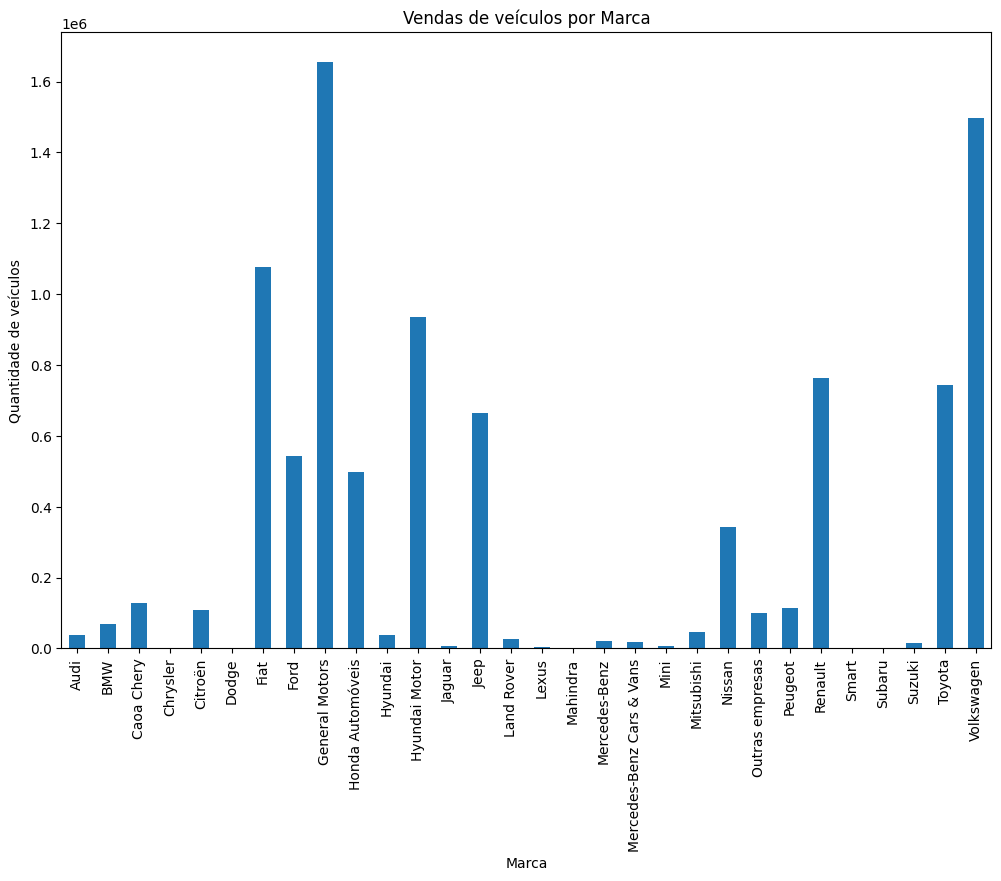

In [ ]:
#plotagem em relação a venda total de 2018 a 2023 em relação as marcas
df.groupby('nome_marca')['qtd_veiculos'].sum().plot(figsize=(12,8), kind='bar')

plt.xlabel('Marca')
plt.ylabel('Quantidade de veículos')
plt.title('Vendas de veículos por Marca')

plt.show()

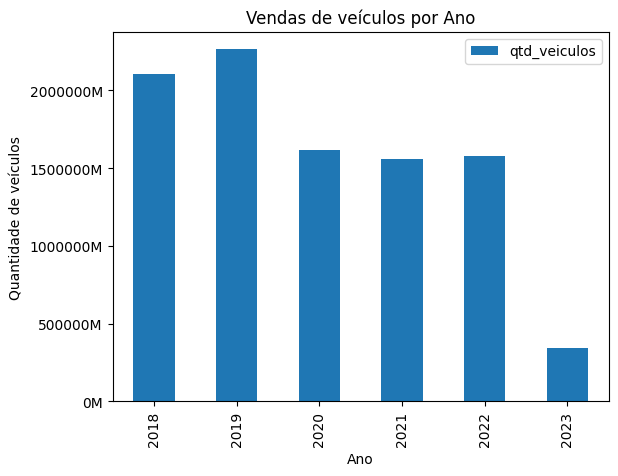

In [ ]:
#plotagem em relação ao total de vendas por ano
grafico = df.groupby(df['ano']).sum(['qtd_veiculos']).plot(kind='bar', stacked=True)

grafico.yaxis.set_major_formatter('{:.0f}M'.format)

plt.xlabel('Ano')
plt.ylabel('Quantidade de veículos')
plt.title('Vendas de veículos por Ano')

plt.show()

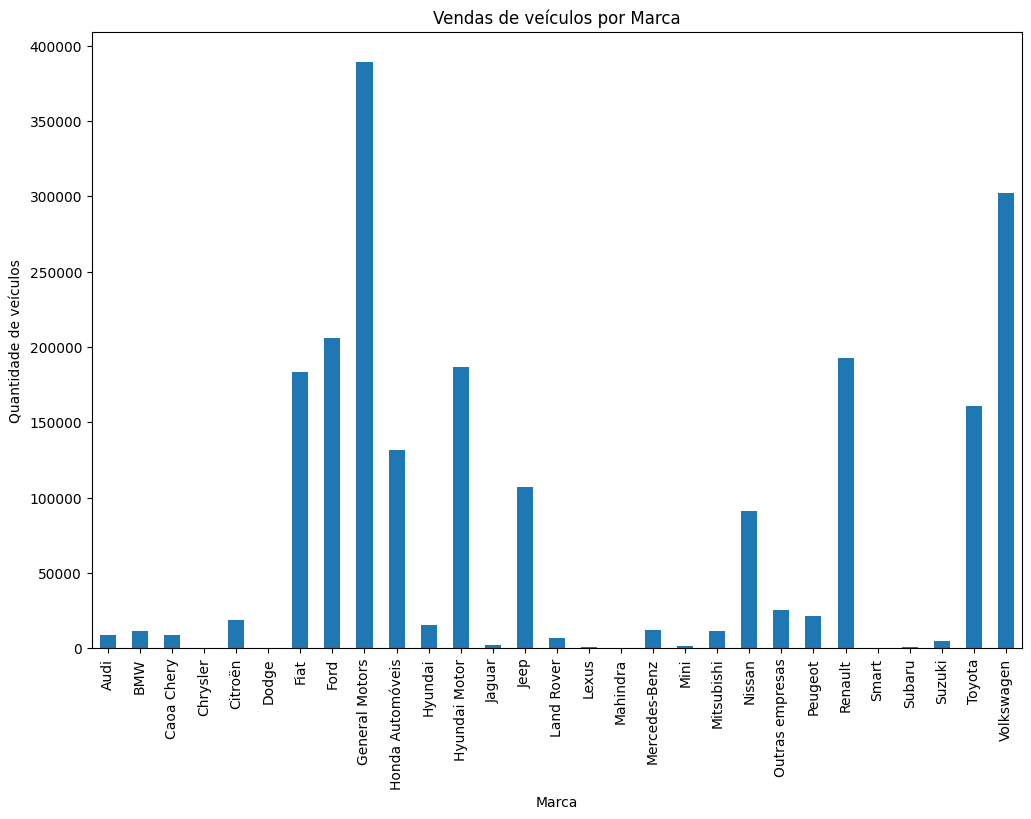

In [ ]:
#plotagem utilizando os df com o filtro por ano em relação a venda total por marca

dados_2018.groupby('nome_marca')['qtd_veiculos'].sum().plot(figsize=(12,8), kind='bar', stacked=True)

plt.xlabel('Marca')
plt.ylabel('Quantidade de veículos')
plt.title('Vendas de veículos por Marca')

plt.show()

Text(0, 0.5, 'Total de vendas')

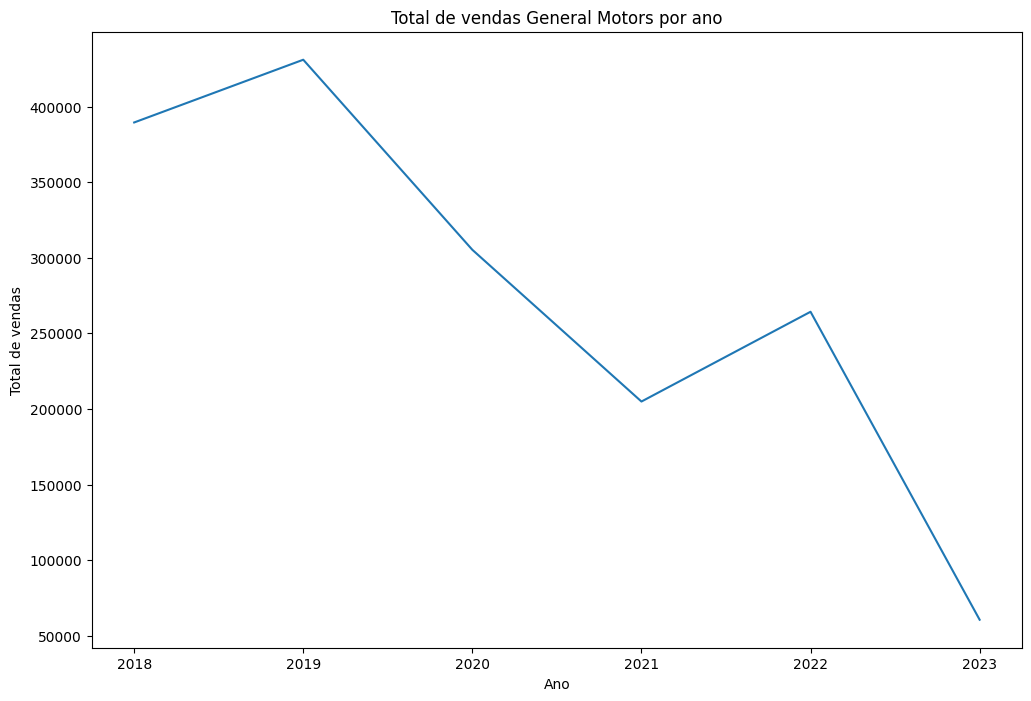

In [ ]:
#Analisando a produção da marca que lídera as vendas -> General Motors

df[df['nome_marca'] == 'General Motors'].groupby('ano')['qtd_veiculos'].sum().plot(figsize=(12,8), kind='line')

plt.title('Total de vendas General Motors por ano')
plt.xlabel('Ano')
plt.ylabel('Total de vendas')

##10) Dataset -> bucket

In [ ]:
#carregando o dataframe tratado para o bucket

df.to_csv('gs://projetofinal1/tratados/venda_empresa.csv', index=False)

##11) Dataset -> MongoDB

In [ ]:
#df -> dicionário -> MongoDB

df_dict = df.to_dict('records')

colecao.insert_many(df_dict)

In [ ]:
#confirmando se houve a inserção dos dados
doc_count = colecao.count_documents({})
print(doc_count)

1749
